In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import f1_score, balanced_accuracy_score



sys.path.insert(0, os.path.abspath("python_packages"))
from python_packages import *
from src import *

# Also add the current directory to ensure all modules can be found
sys.path.append('.')

In [26]:
# Create additional t-SNE visualizations comparing different feature representations
def create_comprehensive_tsne_comparison(feature_sets, labels, split_to_plot = 'train'):
    """
    Create comprehensive t-SNE comparison across different feature representations
    """    
    # Set up colors
    unique_labels = np.unique(labels)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))
    class_names = {0: 'BI-RADS 1', 1: 'BI-RADS 2', 2: 'BI-RADS 3', 3: 'BI-RADS 4', 4: 'BI-RADS 5'}
    
    # Calculate optimal subplot layout
    n_features = len(feature_sets)
    n_cols = 3  # Fixed 3 columns for better layout
    n_rows = int(np.ceil(n_features / n_cols))
    
    # Create subplots with proper layout
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Flatten axes array for easy indexing (handles both 1D and 2D cases)
    if n_rows == 1:
        axes = axes if n_cols > 1 else [axes]  # Handle single row case
    else:
        axes = axes.flatten()  # Flatten 2D array to 1D
    
    for idx, (feature_name, features_train, features_val, features_test) in enumerate(feature_sets):
        print(f"Computing t-SNE for {feature_name}...")
        if split_to_plot == 'train':
            features = features_train
        elif split_to_plot == 'val':
            features = features_val
        elif split_to_plot == 'test':
            features = features_test
        else:
            raise ValueError("split_to_plot must be 'train', 'val', or 'test'")
        
        # Compute t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
        features_tsne = tsne.fit_transform(features)
        
        # Plot on the correct axis
        ax = axes[idx]
        for i, label in enumerate(unique_labels):
            mask = labels == label
            ax.scatter(features_tsne[mask, 0], features_tsne[mask, 1], 
                      c=[colors[i]], label=f'{class_names.get(label, f"Class {label}")}',
                      alpha=0.7, s=15)
        
        ax.set_title(f't-SNE: {feature_name}\n({features.shape[1]} dimensions)', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('t-SNE Component 1')
        ax.set_ylabel('t-SNE Component 2')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()   

def evaluate_svm_classifier(X_train, y_train, X_val, y_val, X_test, y_test, feature_name):
    """
    Train and evaluate an RBF SVM classifier with comprehensive metrics
    """
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train RBF SVM
    svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
    #svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)
    
    # Make predictions
    test_pred = svm_classifier.predict(X_test_scaled)
    
    # Calculate comprehensive metrics
    test_acc_macro = balanced_accuracy_score(y_test, test_pred)  # Overall accuracy
    test_f1_macro = f1_score(y_test, test_pred, average='macro')
    test_f1_weighted = f1_score(y_test, test_pred, average='weighted')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    
    
    results = {
        'feature_name': feature_name,
        'feature_dims': X_train.shape[1],
        'test_acc_macro': test_acc_macro,
        'test_f1_macro': test_f1_macro,
        'test_f1_weighted': test_f1_weighted,
        'confusion_matrix': cm,
        'test_predictions': test_pred,
        'test_labels': y_test
    }
    
    return results, svm_classifier
    
def compare_feature_transformations_svm_clean(feature_sets, label_sets):
    """
    Clean version with execution tracking to prevent duplicate display
    """
    
    # Store results
    all_results = []
    
    print("Comparing Feature Transformations with RBF SVM...")
    print("=" * 70)
    
    for i, (feature_name, X_train, X_val, X_test) in enumerate(feature_sets):
        print(f"\n[{i+1}/{len(feature_sets)}] 🔍 {feature_name}")
        print(f"Dimensions: {X_train.shape[1]}")
        print("-" * 50)
        
        try:
            results, trained_svm = evaluate_svm_classifier(
                X_train, label_sets[0],
                X_val, label_sets[1],
                X_test, label_sets[2],
                feature_name
            )
            all_results.append(results)
            
            print(f" Accuracy: {results['test_acc_macro']:.4f} | F1: {results['test_f1_macro']:.4f}")
            
        except Exception as e:
            print(f" ERROR: {str(e)}")
    
    print(f"\n Execution completed: {len(all_results)} evaluations")
    return all_results


def plot_confusion_matrices_comparison(all_results):
    """
    Create a comprehensive confusion matrix comparison plot
    """
    n_methods = len(all_results)
    
    # Create figure with subplots
    fig, axes = plt.subplots(int(np.ceil(n_methods / 3)), 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Get unique class labels
    all_labels = set()
    for result in all_results:
        all_labels.update(result['test_labels'])
        all_labels.update(result['test_predictions'])
    class_labels = sorted(list(all_labels))
    
    for idx, result in enumerate(all_results):
        ax = axes[idx]
        
        # Plot confusion matrix
        cm = result['confusion_matrix']
        im = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                        xticklabels=class_labels, yticklabels=class_labels)
        
        # Add title with metrics
        title = f"{result['feature_name']}\n"
        title += f"Macro Acc: {result['test_acc_macro']:.3f}, "
        title += f"Macro F1: {result['test_f1_macro']:.3f}\n"
        title += f"Dims: {result['feature_dims']}"
        
        ax.set_title(title, fontsize=11, pad=20)
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
    
    # Remove empty subplots if any
    for idx in range(n_methods, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    return fig
    

# Ideas
Training two networks - on CC and MLO images - View_Cancer dataloader to later use Breast_dataloader and ajive them to check the joint component.

In [2]:
breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="images_png_396",
    image_format="png",
    norm_kind="dataset_zscore",
    batch_size=32,  
    num_workers=1,
    task=1,
    use_train_sampler=False,            # Disable weighted sampling for feature extraction - true train dataset
)
model_MLO = Single_view_model.load_from_checkpoint('artifacts/model-gvwwbcjp:v0/model.ckpt')
model_CC = Single_view_model.load_from_checkpoint('artifacts/model-z6qm6vzp:v0/model.ckpt')

In [ ]:
def get_featurized_data(dataloader, model, model1):
    """
    Get the full featurized dataset from a dataloader.
    """
    model.to('mps')
    model.eval()
    model1.to('mps')
    model1.eval()
    with torch.no_grad():
        all_MLO_features = []
        all_CC_features = []

        all_labels = []

        for batch in tqdm.tqdm(dataloader, desc="Featurizing dataset"):
            x, y1, y2 = batch
            y = y1 if model.task == 1 else y2
            x = [item.to('mps') for item in x]
            y = y.to('mps')
            all_labels.append(y)

            x_MLO = [model.resnet(x[1])]

            x_CC = [model1.resnet(x[0])]

            all_MLO_features.append(torch.cat(x_MLO, dim=1))

            all_CC_features.append(torch.cat(x_CC, dim=1))

        all_MLO_features = torch.cat(all_MLO_features, dim=0)
        all_CC_features = torch.cat(all_CC_features, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

    return all_MLO_features, all_CC_features, all_labels


In [ ]:
def process_and_save_all_splits(breast_loader, model_MLO, model_CC, save_dir='saved_features'):
    """
    Process train, test, and validation dataloaders and save features and labels.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    splits = {
        'train': breast_loader.train_dataloader(),
        'val': breast_loader.val_dataloader(),
        'test': breast_loader.test_dataloader()
    }
    
    for split_name, dataloader in splits.items():
        print(f"Processing {split_name} split...")
        
        MLO_features, CC_features, labels = get_featurized_data(
            dataloader, model_MLO, model_CC
        )
        
        # Move to CPU before saving
        MLO_features = MLO_features.cpu()
        CC_features = CC_features.cpu()
        labels = labels.cpu()

        # Also save as dictionary for convenience
        torch.save({
            'MLO_features': MLO_features,
            'CC_features': CC_features,
            'labels': labels
        }, f'{save_dir}/all_data_{split_name}.pt')
        
        print(f"Saved {split_name} split with shapes:")
        print(f"  MLO features: {MLO_features.shape}")
        print(f"  CC features: {CC_features.shape}")
        print(f"  Labels: {labels.shape}")
        print()


In [ ]:
#process_and_save_all_splits(breast_loader, model_MLO, model_CC, save_dir='saved_features/MLOvsCC')

Processing train split...


Featurizing dataset: 100%|██████████| 200/200 [02:11<00:00,  1.52it/s]


Saved train split with shapes:
  MLO features: torch.Size([6400, 512])
  CC features: torch.Size([6400, 512])
  Labels: torch.Size([6400])

Processing val split...


Featurizing dataset: 100%|██████████| 50/50 [00:40<00:00,  1.24it/s]


Saved val split with shapes:
  MLO features: torch.Size([1598, 512])
  CC features: torch.Size([1598, 512])
  Labels: torch.Size([1598])

Processing test split...


Featurizing dataset: 100%|██████████| 63/63 [01:16<00:00,  1.22s/it]


Saved test split with shapes:
  MLO features: torch.Size([2000, 512])
  CC features: torch.Size([2000, 512])
  Labels: torch.Size([2000])



In [3]:
train_data = torch.load('saved_features/MLOvsCC/all_data_train.pt')
train_MLO_features = train_data['MLO_features'].numpy()
train_CC_features = train_data['CC_features'].numpy()
train_cancer_labels = train_data['labels'].numpy()


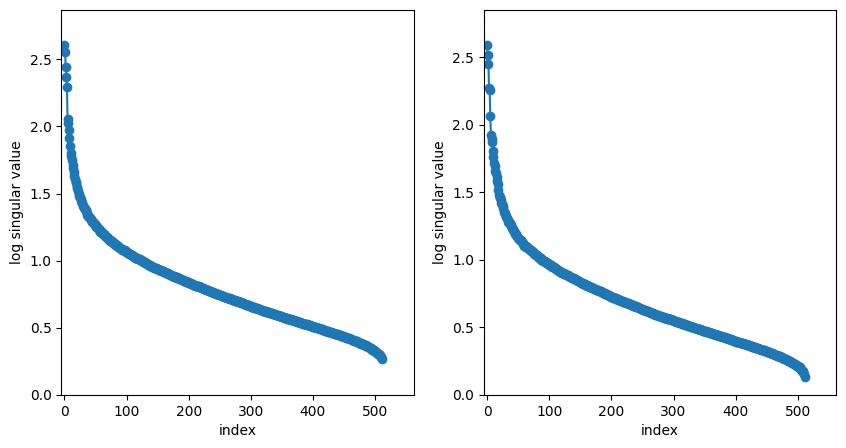

In [4]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(train_MLO_features).plot_scree(log = True)
plt.subplot(1, 2, 2)
PCA().fit(train_CC_features).plot_scree(log = True)

In [5]:
aj = AJIVE(init_signal_ranks=[20,20], n_jobs=16, center=True)
aj.fit([train_MLO_features, train_CC_features])
aj.summary()


'AJIVE, joint rank: 5, view 0 indiv rank: 16, view 1 indiv rank: 17'

In [6]:
val_data = torch.load('saved_features/MLOvsCC/all_data_val.pt')
val_MLO_features = val_data['MLO_features'].numpy()
val_CC_features = val_data['CC_features'].numpy()
val_labels = val_data['labels'].numpy()

test_data = torch.load('saved_features/MLOvsCC/all_data_test.pt')
test_MLO_features = test_data['MLO_features'].numpy()
test_CC_features = test_data['CC_features'].numpy()
test_labels = test_data['labels'].numpy()

label_sets = (train_cancer_labels, val_labels, test_labels)


In [7]:
# Create enriched features with consistent transformations
train_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(train_MLO_features), aj.view_specific_[1].joint_.transform(train_CC_features)])
val_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(val_MLO_features), aj.view_specific_[1].joint_.transform(val_CC_features)])
test_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(test_MLO_features), aj.view_specific_[1].joint_.transform(test_CC_features)])

train_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(train_MLO_features), aj.view_specific_[1].individual_.transform(train_CC_features)])
val_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(val_MLO_features), aj.view_specific_[1].individual_.transform(val_CC_features)])
test_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(test_MLO_features), aj.view_specific_[1].individual_.transform(test_CC_features)])

# Combined enriched features (joint + individual)
train_cancer_enriched = np.hstack([train_joint_components, train_individual_components])
val_cancer_enriched = np.hstack([val_joint_components, val_individual_components])
test_cancer_enriched = np.hstack([test_joint_components, test_individual_components])

train_full_ajive = np.hstack([train_MLO_features, train_CC_features, train_cancer_enriched])
val_full_ajive = np.hstack([val_MLO_features, val_CC_features, val_cancer_enriched])
test_full_ajive = np.hstack([test_MLO_features, test_CC_features, test_cancer_enriched])

In [9]:
feature_sets = [
        ('MLO Features Only', train_MLO_features, val_MLO_features, test_MLO_features),
        ('CC Features Only', train_CC_features, val_CC_features, test_CC_features),
        ('Concatenated (MLO + CC)', 
         np.hstack([train_MLO_features, train_CC_features]),
         np.hstack([val_MLO_features, val_CC_features]),
         np.hstack([test_MLO_features, test_CC_features])),
        ('Joint Components Only', train_joint_components, val_joint_components, test_joint_components),
        ('Individual Components Only', train_individual_components, val_individual_components, test_individual_components),
        ('AJIVE Enriched (Joint + Individual)', train_cancer_enriched, val_cancer_enriched, test_cancer_enriched),
        ('Full + AJIVE', train_full_ajive, val_full_ajive, test_full_ajive)
    ]

Computing t-SNE for MLO Features Only...
Computing t-SNE for CC Features Only...
Computing t-SNE for Concatenated (MLO + CC)...
Computing t-SNE for Joint Components Only...
Computing t-SNE for Individual Components Only...
Computing t-SNE for AJIVE (Joint + Individual)...
Computing t-SNE for Full + AJIVE...


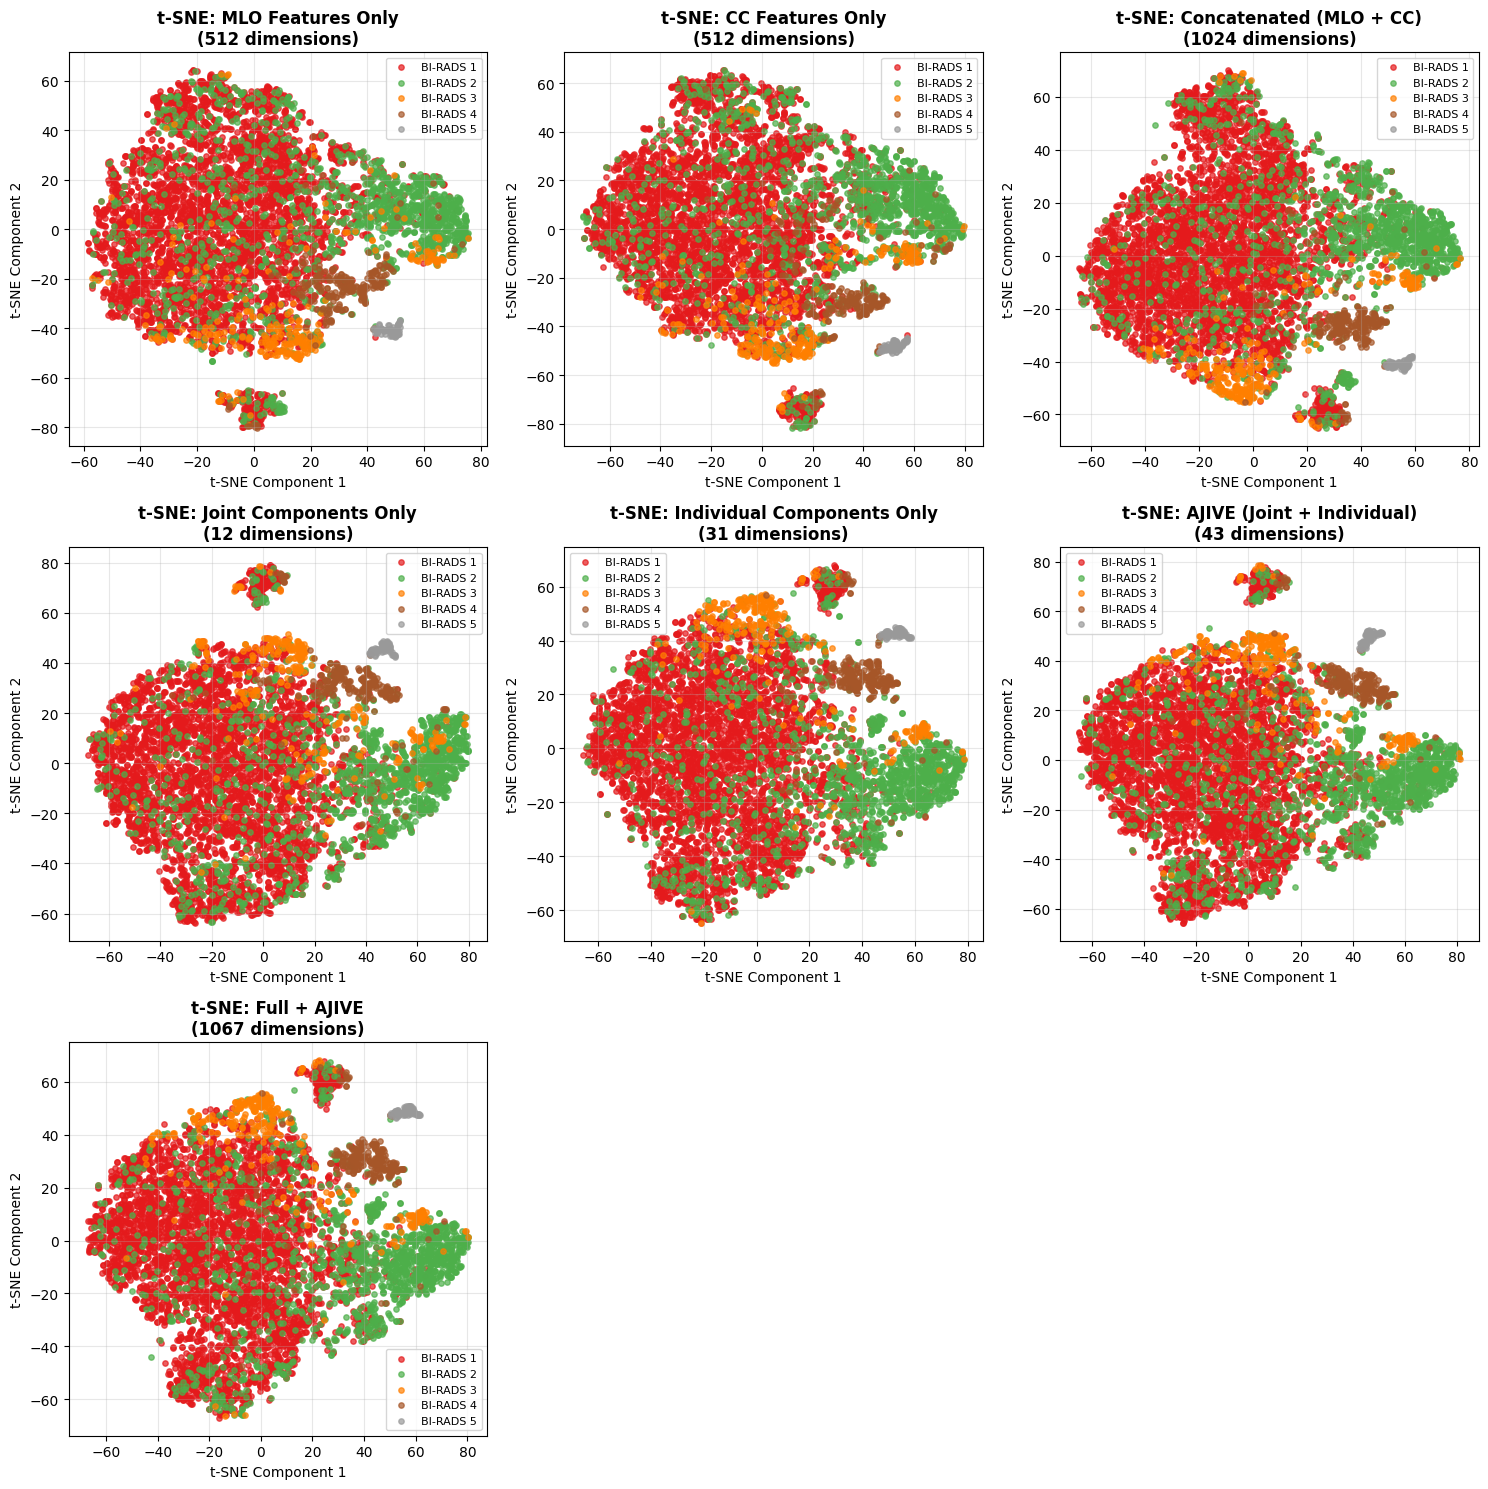

In [27]:

create_comprehensive_tsne_comparison(
    feature_sets,
    train_cancer_labels,
    split_to_plot='train'
)

Computing t-SNE for MLO Features Only...


/Users/jazav7774/UiT/FYS-8603/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Computing t-SNE for CC Features Only...


/Users/jazav7774/UiT/FYS-8603/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Computing t-SNE for Concatenated (MLO + CC)...


/Users/jazav7774/UiT/FYS-8603/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Computing t-SNE for Joint Components Only...


/Users/jazav7774/UiT/FYS-8603/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Computing t-SNE for Individual Components Only...


/Users/jazav7774/UiT/FYS-8603/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Computing t-SNE for AJIVE (Joint + Individual)...


/Users/jazav7774/UiT/FYS-8603/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Computing t-SNE for Full + AJIVE...


/Users/jazav7774/UiT/FYS-8603/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


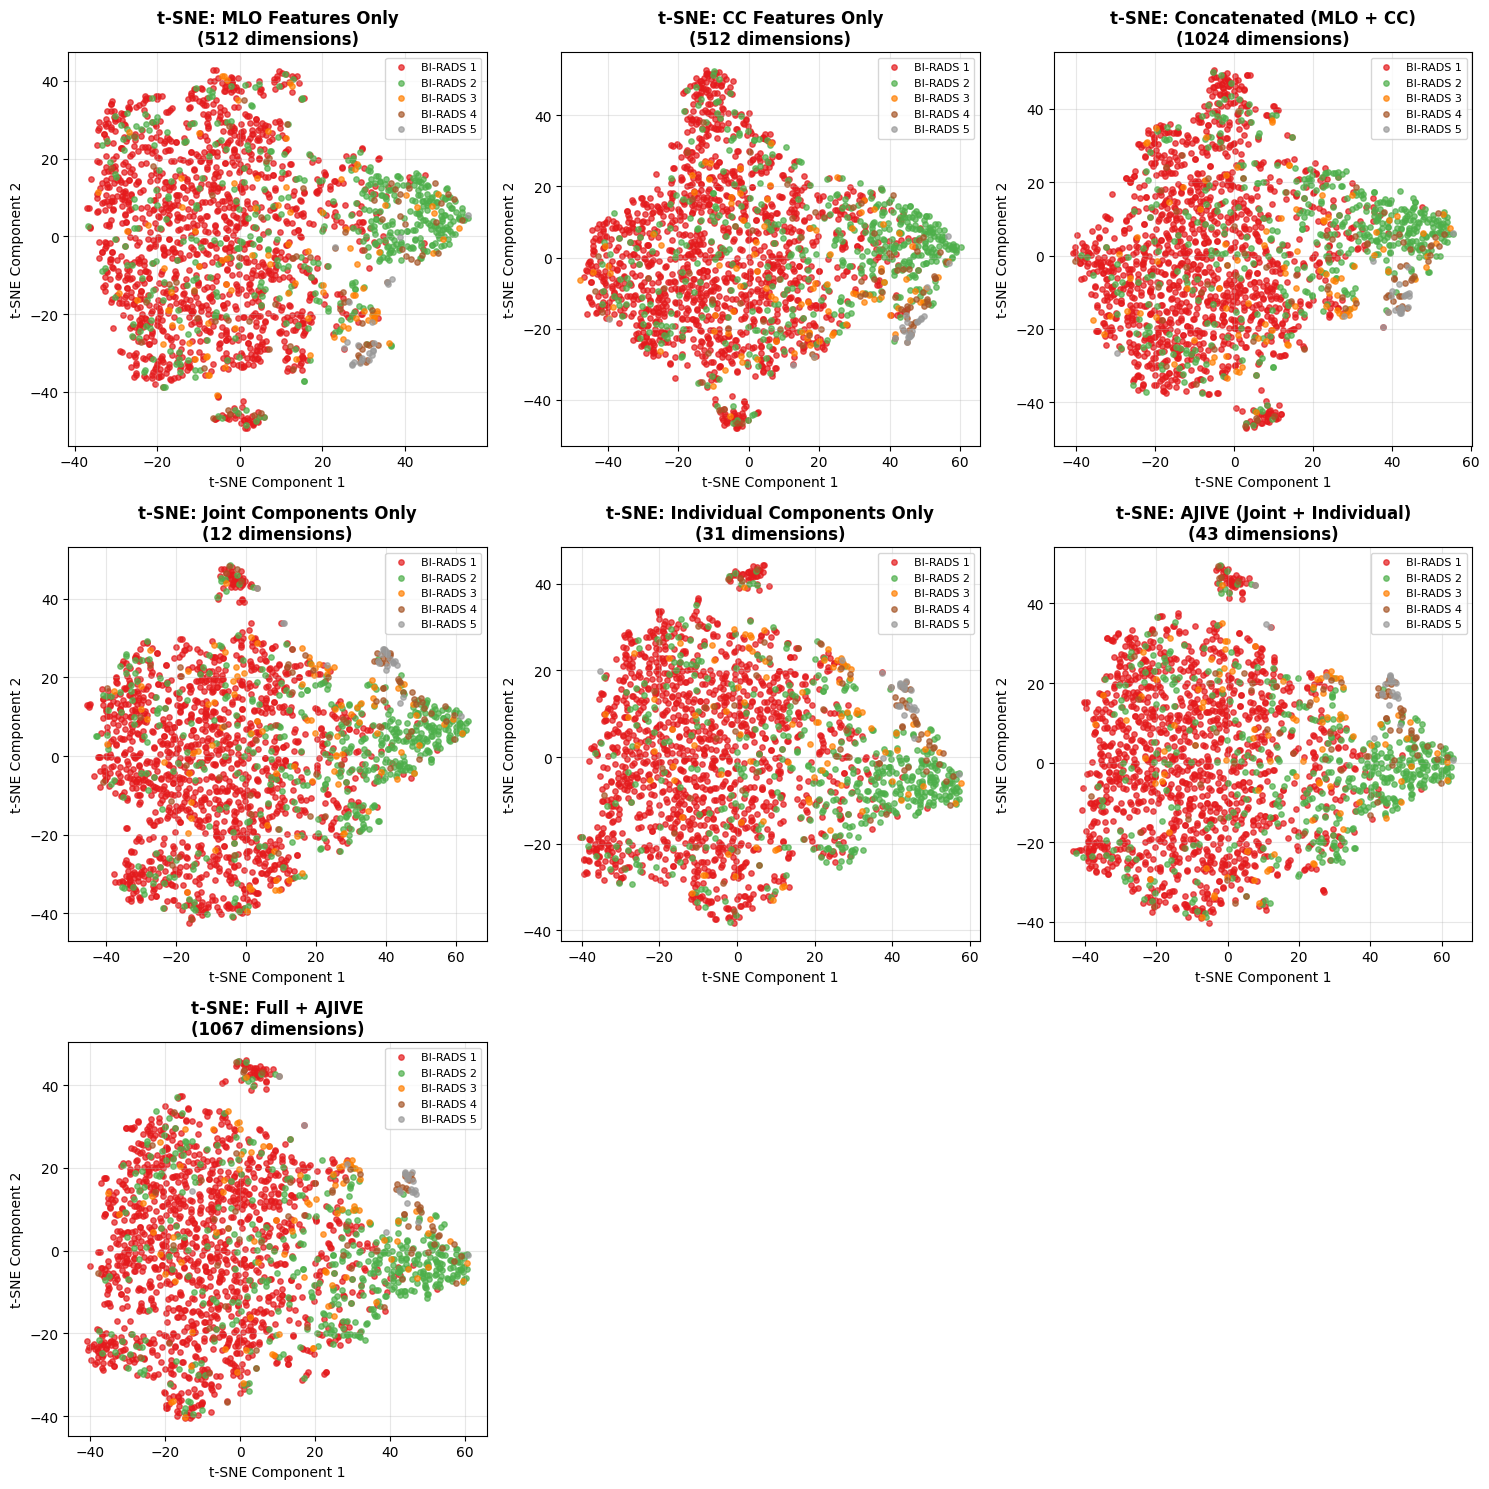

In [25]:

create_comprehensive_tsne_comparison(
    feature_sets,
    test_labels,
    split_to_plot='test'
)

In [10]:
# CLEAN EXECUTION - Force fresh run and clear display issues
from IPython.display import clear_output
import time

# Clear all previous output from this notebook session
clear_output(wait=True)
time.sleep(0.5)

# Delete existing results to force fresh execution
if 'all_results' in globals():
    print(f"Deleting existing all_results with {len(all_results)} items")
    del all_results
    
# Force garbage collection
import gc
gc.collect()

# Create a modified version with unique execution tracking


# Execute the clean version
all_results = compare_feature_transformations_svm_clean(feature_sets, label_sets)

print("\n Final Summary:")
print(f"Total results: {len(all_results)}")
for i, result in enumerate(all_results):
    print(f"  {i+1}. {result['feature_name']}: F1={result['test_f1_macro']:.4f}")

Comparing Feature Transformations with RBF SVM...

[1/7] 🔍 MLO Features Only
Dimensions: 512
--------------------------------------------------
 Accuracy: 0.4038 | F1: 0.4473

[2/7] 🔍 CC Features Only
Dimensions: 512
--------------------------------------------------
 Accuracy: 0.4144 | F1: 0.4568

[3/7] 🔍 Concatenated (MLO + CC)
Dimensions: 1024
--------------------------------------------------
 Accuracy: 0.3932 | F1: 0.4374

[4/7] 🔍 Joint Components Only
Dimensions: 10
--------------------------------------------------
 Accuracy: 0.4249 | F1: 0.4732

[5/7] 🔍 Individual Components Only
Dimensions: 33
--------------------------------------------------
 Accuracy: 0.4245 | F1: 0.4719

[6/7] 🔍 AJIVE Enriched (Joint + Individual)
Dimensions: 43
--------------------------------------------------
 Accuracy: 0.4264 | F1: 0.4737

[7/7] 🔍 Full + AJIVE
Dimensions: 1067
--------------------------------------------------
 Accuracy: 0.3932 | F1: 0.4374

 Execution completed: 7 evaluations

 Final 

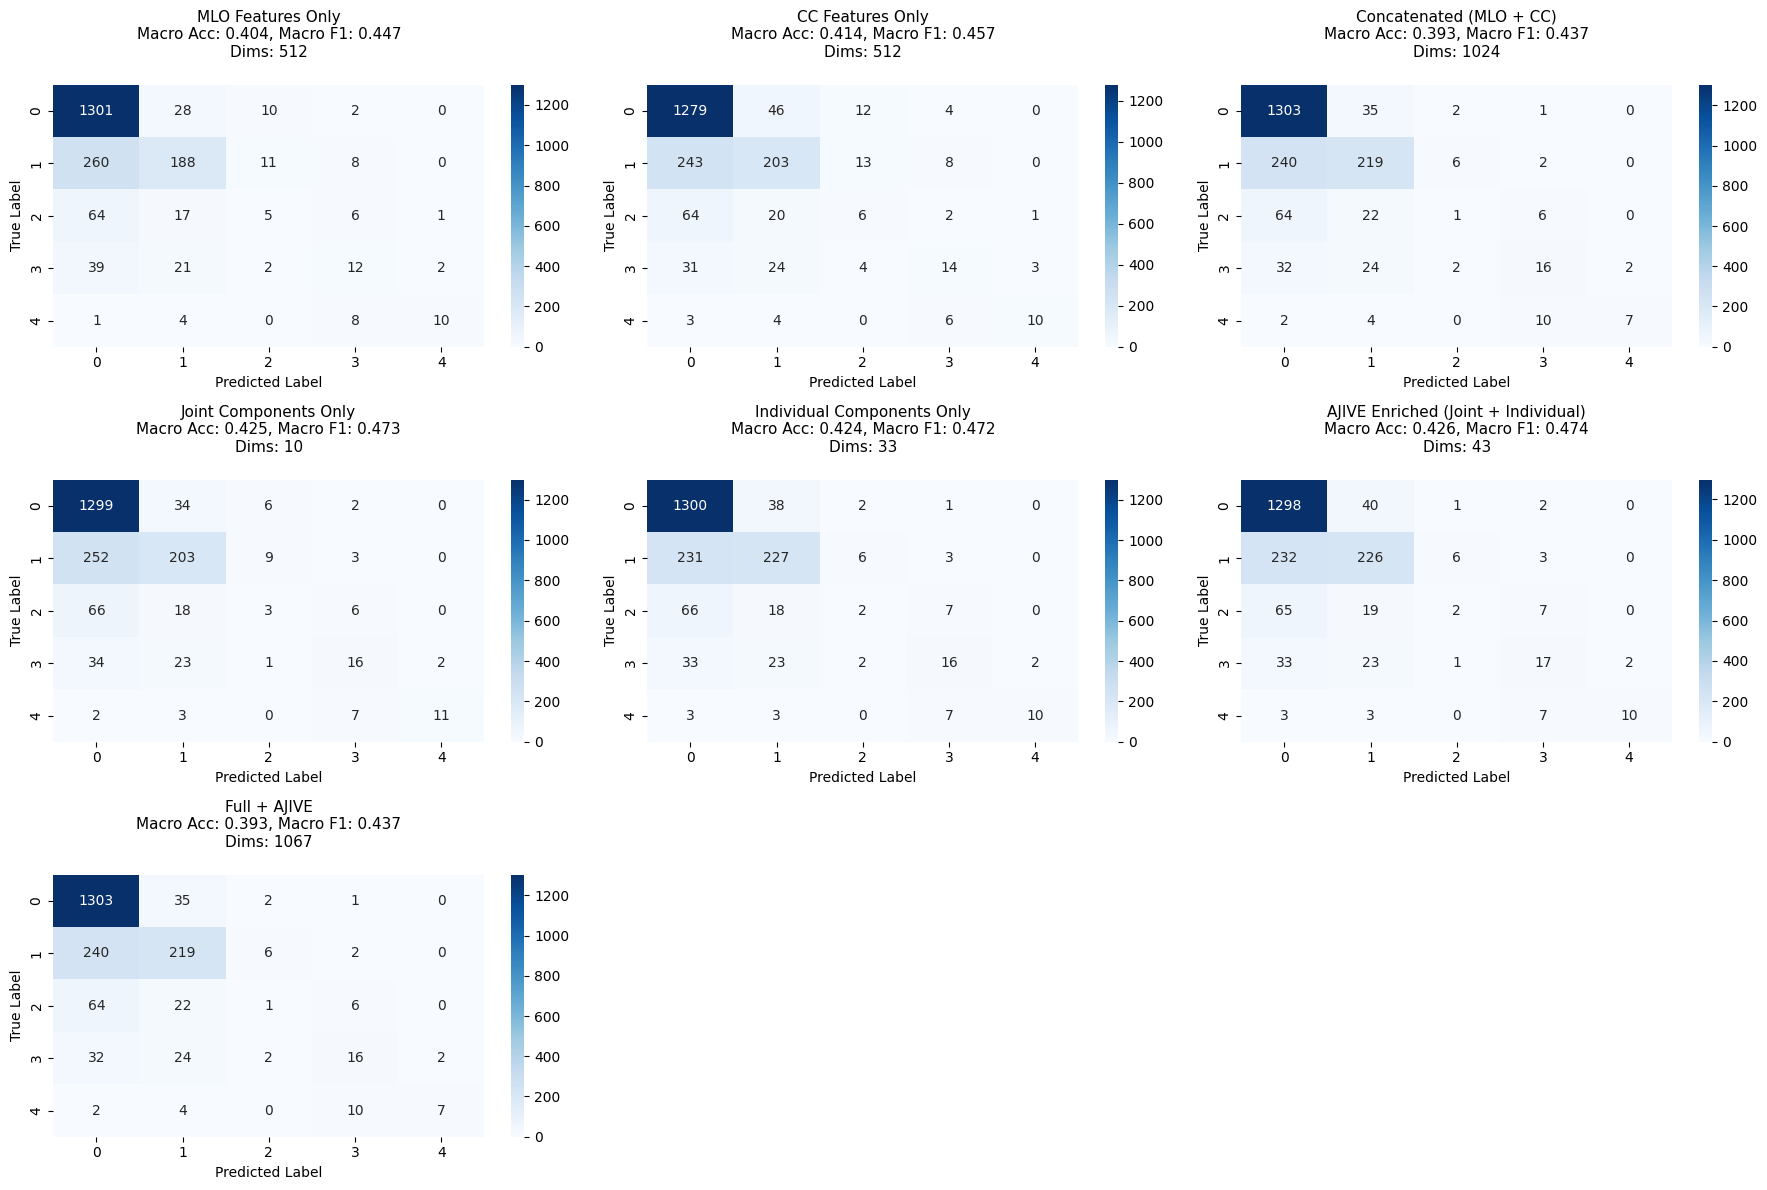

In [21]:


# Create visualizations
confusion_fig = plot_confusion_matrices_comparison(all_results)
#summary_df = create_performance_summary(all_results)

# Use a fixed feature extractor (Mirai) to extract features from CC and MLO and then compare those

In [6]:
sys.path.append('Mirai_Risk_Prediction_Model')
from Mirai_Risk_Prediction_Model.asymmetry_model.mirai_localized_dif_head import extract_mirai_backbone
encoder = extract_mirai_backbone('Mirai_Risk_Prediction_Model/asymmetry_model/mgh_mammo_MIRAI_Base_May20_2019.p')

/Users/jazav7774/UiT/FYS-8603/.venv/lib/python3.12/site-packages/torch/serialization.py:1580: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [7]:
import torch.nn as nn

breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="images_png_396",
    image_format="png",
    norm_kind="dataset_zscore",
    batch_size=32,  
    num_workers=1,
    task=1,
    use_train_sampler=False,            # Disable weighted sampling for feature extraction - true train dataset
)

#model = Four_view_single_featurizer(5, weights_file = 'checkpoints/One_view_resnet.ckpt')

# First tried the mirai encoder, but it didnt give good features at all - maybe different preprocessing?
mirai_feature_extractor = nn.Sequential(
    encoder,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)
#mirai_feature_extractor(torch.randn(5,3,512,512)).shape
#model.resnet(torch.randn(5,3,512,512)).shape

model = Single_view_model.load_from_checkpoint('artifacts/model-pagctwl3:v0/model.ckpt')


In [8]:
def get_featurized_data(dataloader, model, task = 1):
    """
    Get the full featurized dataset from a dataloader. Using one mirai featurizer
    """
    model.to('mps')
    model.eval()
    with torch.no_grad():
        all_MLO_features = []
        all_CC_features = []

        all_labels = []

        for batch in tqdm.tqdm(dataloader, desc="Featurizing dataset"):
            x, y1, y2 = batch
            y = y1 if task == 1 else y2
            x = [item.to('mps') for item in x]
            y = y.to('mps')
            all_labels.append(y)

            x_CC = [model.resnet(x[0])]
            #x_CC = model(x[0])

            x_MLO = [model.resnet(x[1])]
            #x_MLO = model(x[1])

            all_MLO_features.append(torch.cat(x_MLO, dim=1))
            #all_MLO_features.append(x_MLO)

            all_CC_features.append(torch.cat(x_CC, dim=1))
            #all_CC_features.append(x_CC)

        all_MLO_features = torch.cat(all_MLO_features, dim=0)
        all_CC_features = torch.cat(all_CC_features, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

    return all_MLO_features, all_CC_features, all_labels

In [9]:
def process_and_save_all_splits(breast_loader, model, save_dir='saved_features/cc+MLO_mirai/'):
    """
    Process train, test, and validation dataloaders and save features and labels.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    splits = {
        'train': breast_loader.train_dataloader(),
        'val': breast_loader.val_dataloader(),
        'test': breast_loader.test_dataloader()
    }
    
    for split_name, dataloader in splits.items():
        print(f"Processing {split_name} split...")
        
        MLO_features, CC_features, labels = get_featurized_data(
            dataloader, model
        )
        
        # Move to CPU before saving
        MLO_features = MLO_features.cpu()
        CC_features = CC_features.cpu()
        labels = labels.cpu()

        # Also save as dictionary for convenience
        torch.save({
            'MLO_features': MLO_features,
            'CC_features': CC_features,
            'labels': labels
        }, f'{save_dir}/all_data_{split_name}.pt')
        
        print(f"Saved {split_name} split with shapes:")
        print(f"  MLO features: {MLO_features.shape}")
        print(f"  CC features: {CC_features.shape}")
        print(f"  Labels: {labels.shape}")
        print()

In [ ]:
#process_and_save_all_splits(breast_loader, model, save_dir='saved_features/CC+MLO_1resnet/')

Processing train split...


Featurizing dataset: 100%|██████████| 200/200 [03:49<00:00,  1.15s/it]


Saved train split with shapes:
  MLO features: torch.Size([6400, 512])
  CC features: torch.Size([6400, 512])
  Labels: torch.Size([6400])

Processing val split...


Featurizing dataset: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


Saved val split with shapes:
  MLO features: torch.Size([1598, 512])
  CC features: torch.Size([1598, 512])
  Labels: torch.Size([1598])

Processing test split...


Featurizing dataset: 100%|██████████| 63/63 [01:35<00:00,  1.52s/it]


Saved test split with shapes:
  MLO features: torch.Size([2000, 512])
  CC features: torch.Size([2000, 512])
  Labels: torch.Size([2000])



In [12]:
train_data = torch.load('saved_features/CC+MLO_1resnet/all_data_train.pt')
train_MLO_features = train_data['MLO_features'].numpy()
train_CC_features = train_data['CC_features'].numpy()
train_cancer_labels = train_data['labels'].numpy()


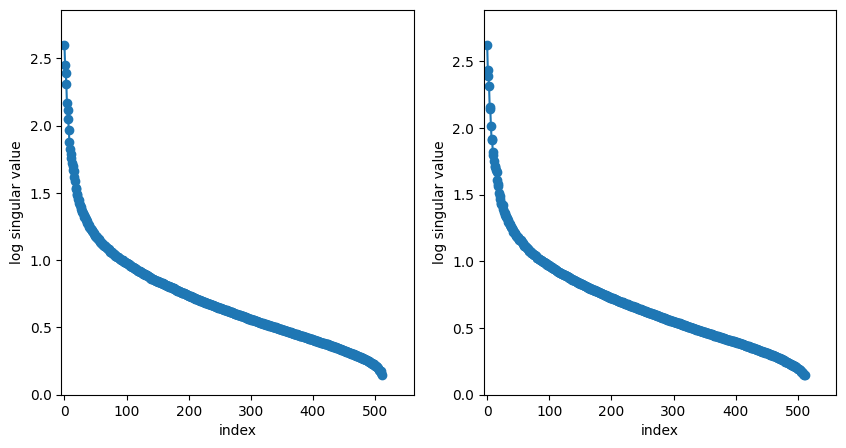

In [13]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(train_MLO_features).plot_scree(log = True)
plt.subplot(1, 2, 2)
PCA().fit(train_CC_features).plot_scree(log = True)

In [14]:
aj = AJIVE(init_signal_ranks=[20,20], n_jobs=16, center=True)
aj.fit([train_MLO_features, train_CC_features])
aj.summary()


'AJIVE, joint rank: 6, view 0 indiv rank: 15, view 1 indiv rank: 16'

In [15]:
val_data = torch.load('saved_features/CC+MLO_1resnet/all_data_val.pt')
val_MLO_features = val_data['MLO_features'].numpy()
val_CC_features = val_data['CC_features'].numpy()
val_labels = val_data['labels'].numpy()

test_data = torch.load('saved_features/CC+MLO_1resnet/all_data_test.pt')
test_MLO_features = test_data['MLO_features'].numpy()
test_CC_features = test_data['CC_features'].numpy()
test_labels = test_data['labels'].numpy()

label_sets = (train_cancer_labels, val_labels, test_labels)

In [16]:
# Create enriched features with consistent transformations
train_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(train_MLO_features), aj.view_specific_[1].joint_.transform(train_CC_features)])
val_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(val_MLO_features), aj.view_specific_[1].joint_.transform(val_CC_features)])
test_joint_components = np.hstack([aj.view_specific_[0].joint_.transform(test_MLO_features), aj.view_specific_[1].joint_.transform(test_CC_features)])

train_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(train_MLO_features), aj.view_specific_[1].individual_.transform(train_CC_features)])
val_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(val_MLO_features), aj.view_specific_[1].individual_.transform(val_CC_features)])
test_individual_components = np.hstack([aj.view_specific_[0].individual_.transform(test_MLO_features), aj.view_specific_[1].individual_.transform(test_CC_features)])

# Combined enriched features (joint + individual)
train_cancer_enriched = np.hstack([train_joint_components, train_individual_components])
val_cancer_enriched = np.hstack([val_joint_components, val_individual_components])
test_cancer_enriched = np.hstack([test_joint_components, test_individual_components])

train_full_ajive = np.hstack([train_MLO_features, train_CC_features, train_cancer_enriched])
val_full_ajive = np.hstack([val_MLO_features, val_CC_features, val_cancer_enriched])
test_full_ajive = np.hstack([test_MLO_features, test_CC_features, test_cancer_enriched])

In [17]:
feature_sets = [
        ('MLO Features Only', train_MLO_features, val_MLO_features, test_MLO_features),
        ('CC Features Only', train_CC_features, val_CC_features, test_CC_features),
        ('Concatenated (MLO + CC)', 
         np.hstack([train_MLO_features, train_CC_features]),
         np.hstack([val_MLO_features, val_CC_features]),
         np.hstack([test_MLO_features, test_CC_features])),
        ('Joint Components Only', train_joint_components, val_joint_components, test_joint_components),
        ('Individual Components Only', train_individual_components, val_individual_components, test_individual_components),
        ('AJIVE (Joint + Individual)', train_cancer_enriched, val_cancer_enriched, test_cancer_enriched),
        ('Full + AJIVE', train_full_ajive, val_full_ajive, test_full_ajive)
    ]

Computing t-SNE for CC...
Computing t-SNE for MLO...
Computing t-SNE for Concatenated (MLO + CC)...
Computing t-SNE for Joint Components...
Computing t-SNE for Individual Components...
Computing t-SNE for Joint_Individual...
Computing t-SNE for Full + AJIVE...


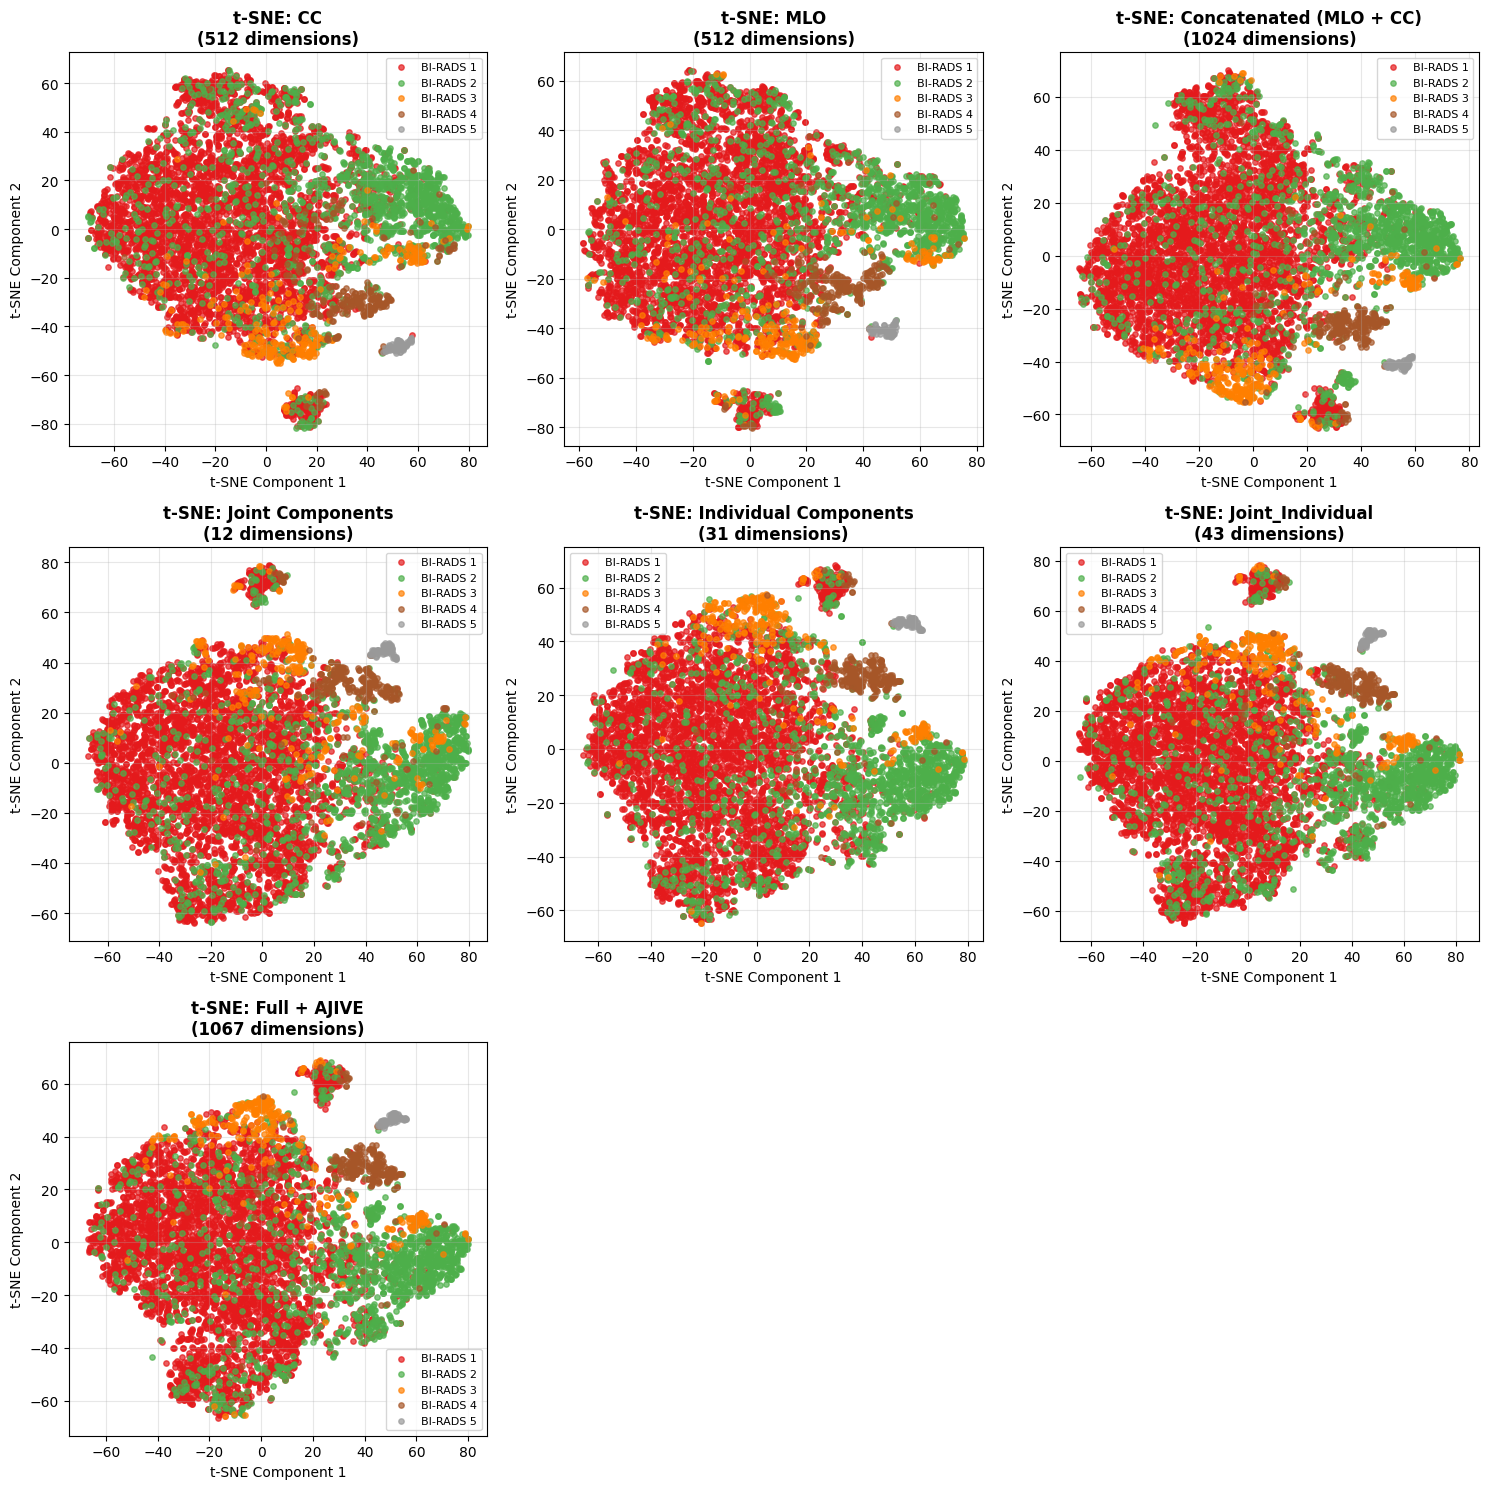

In [ ]:

create_comprehensive_tsne_comparison(
    feature_sets,
    train_cancer_labels,
    split_to_plot='train'
)

Computing t-SNE for MLO Features Only...
Computing t-SNE for CC Features Only...
Computing t-SNE for Concatenated (MLO + CC)...
Computing t-SNE for Joint Components Only...
Computing t-SNE for Individual Components Only...
Computing t-SNE for AJIVE (Joint + Individual)...
Computing t-SNE for Full + AJIVE...


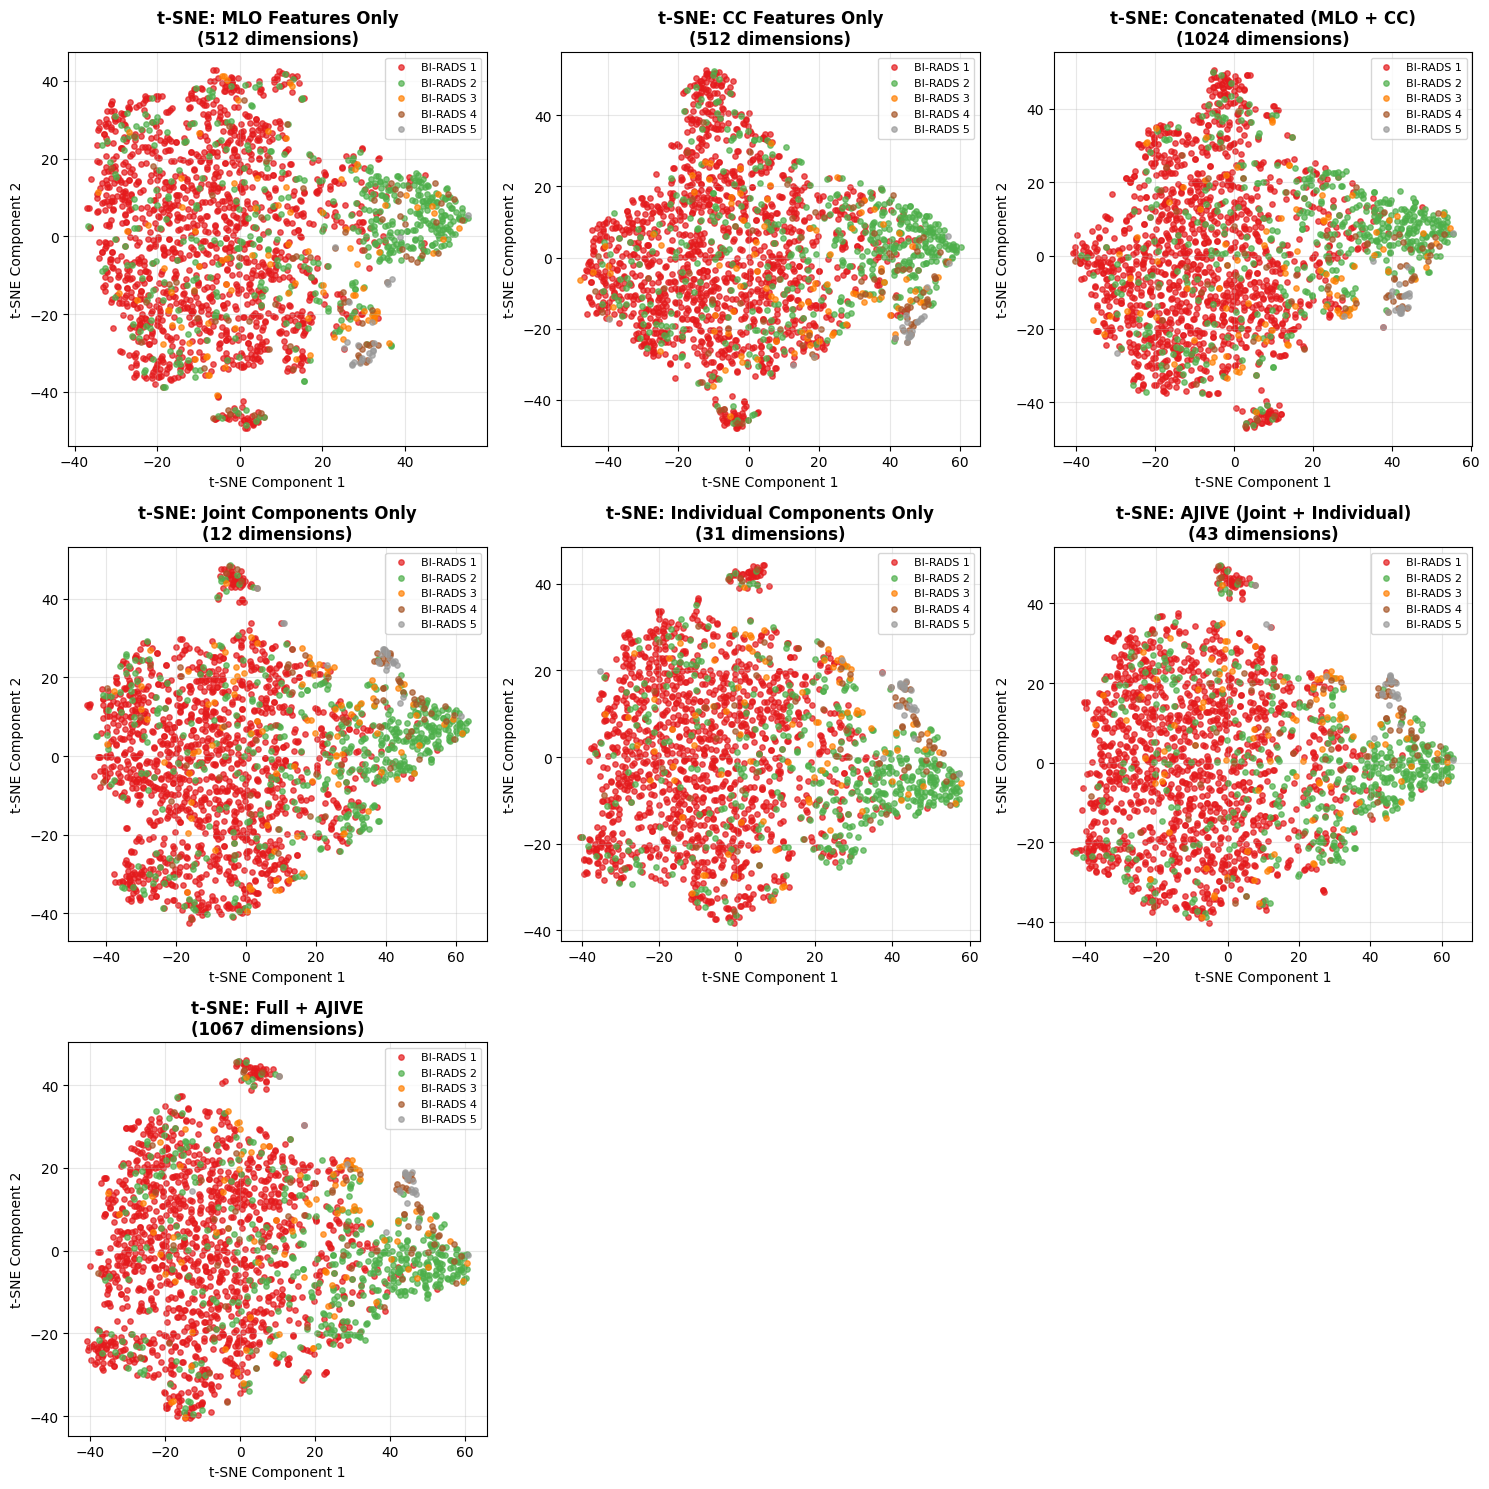

In [28]:

create_comprehensive_tsne_comparison(
    feature_sets,
    test_labels,
    split_to_plot='test'
)

In [18]:

# Execute the clean version
all_results1 = compare_feature_transformations_svm_clean(feature_sets, label_sets)

print("\n Final Summary:")
print(f"Total results: {len(all_results1)}")
for i, result in enumerate(all_results1):
    print(f"  {i+1}. {result['feature_name']}: F1={result['test_f1_macro']:.4f}")

Comparing Feature Transformations with RBF SVM...

[1/7] 🔍 MLO Features Only
Dimensions: 512
--------------------------------------------------
 Accuracy: 0.3913 | F1: 0.4310

[2/7] 🔍 CC Features Only
Dimensions: 512
--------------------------------------------------
 Accuracy: 0.3972 | F1: 0.4412

[3/7] 🔍 Concatenated (MLO + CC)
Dimensions: 1024
--------------------------------------------------
 Accuracy: 0.4165 | F1: 0.4652

[4/7] 🔍 Joint Components Only
Dimensions: 12
--------------------------------------------------
 Accuracy: 0.4269 | F1: 0.4738

[5/7] 🔍 Individual Components Only
Dimensions: 31
--------------------------------------------------
 Accuracy: 0.4061 | F1: 0.4553

[6/7] 🔍 AJIVE (Joint + Individual)
Dimensions: 43
--------------------------------------------------
 Accuracy: 0.4219 | F1: 0.4711

[7/7] 🔍 Full + AJIVE
Dimensions: 1067
--------------------------------------------------
 Accuracy: 0.4192 | F1: 0.4687

 Execution completed: 7 evaluations

 Final Summary:


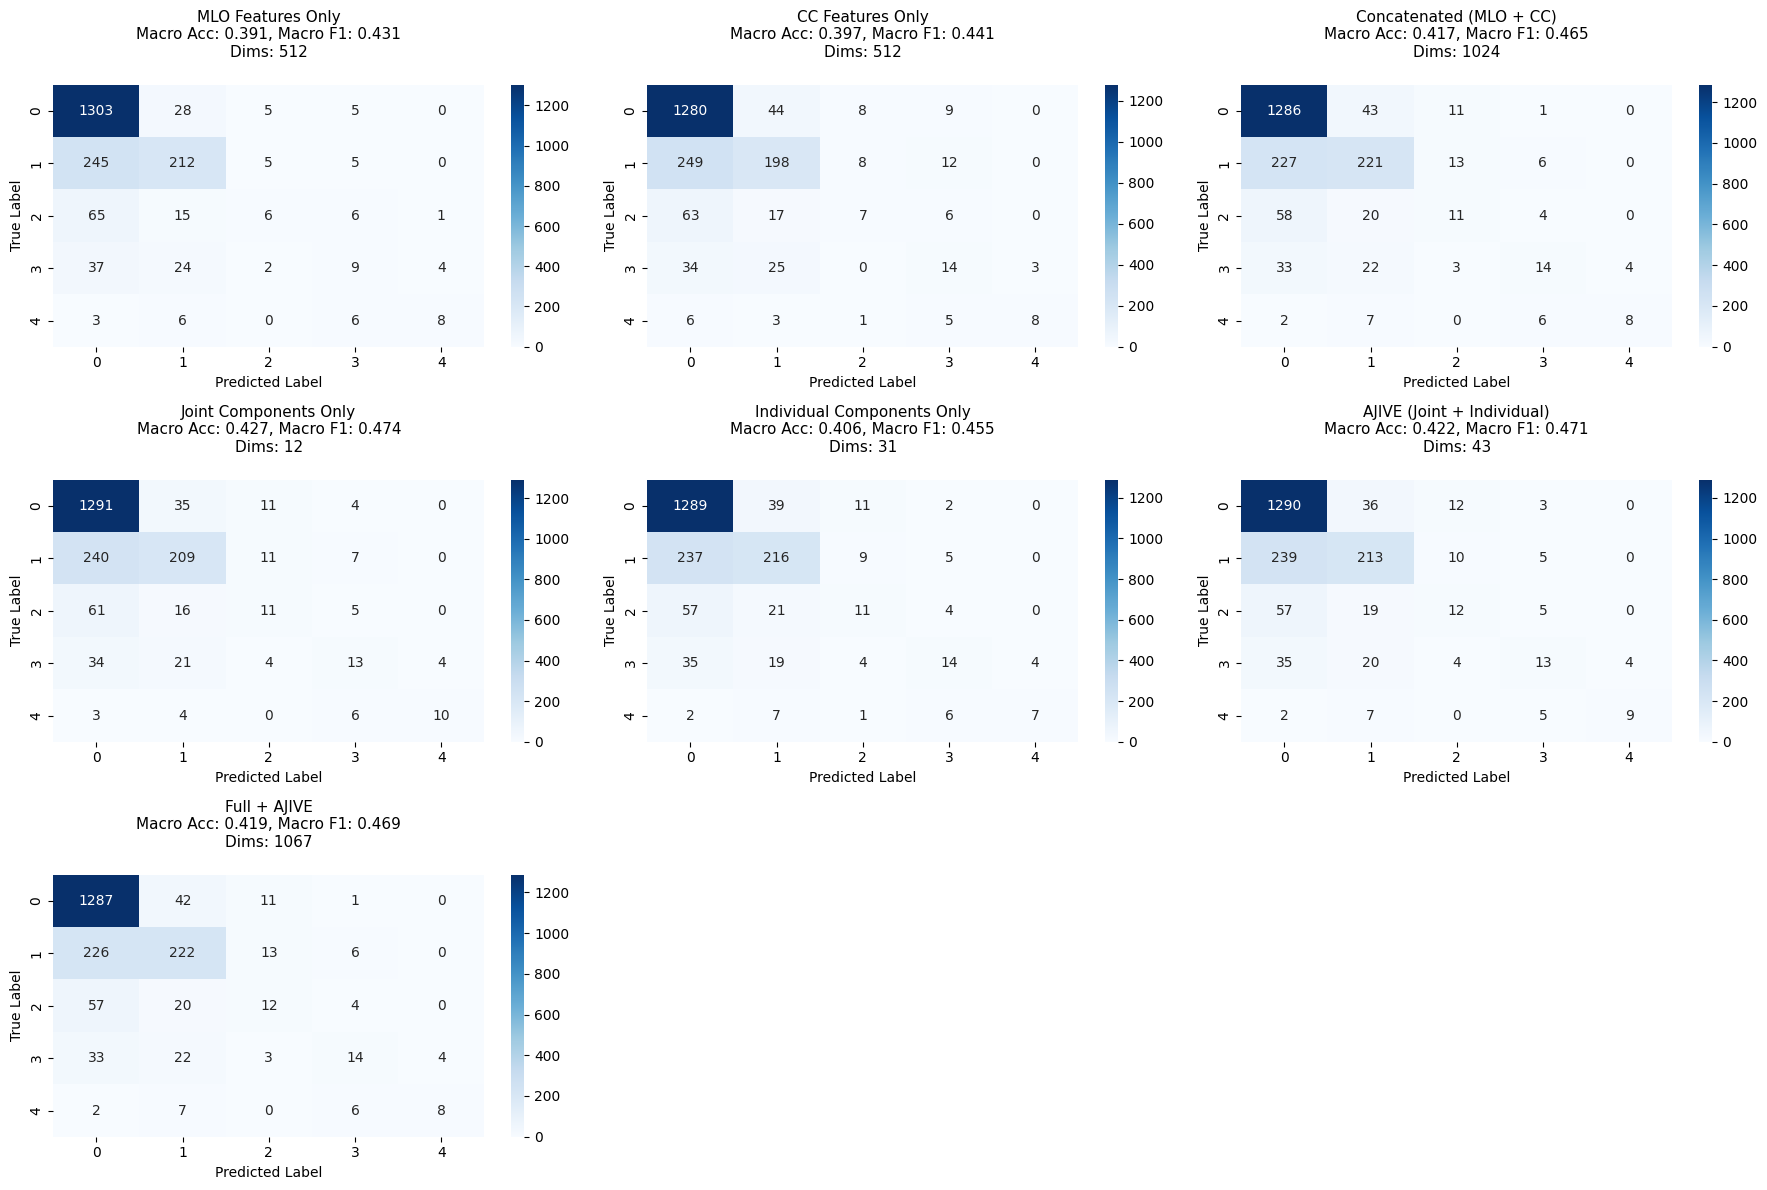

In [22]:
confusion_fig = plot_confusion_matrices_comparison(all_results1)